# `sparse_lap` and `sparse_pflap` quality and speed based on point count

__Goal__: See the relationship between the `sparse_lap` quality and speed based on the number of points used in the algorithm.

__Data__: all `point_counts` * `spacings` * `diag_sizes`

In [26]:
using LAP_julia, TimerOutputs, DataFrames, TableView, JLD2, FileIO, PyPlot, BenchmarkTools, Interact
using LAP_julia: fun_on_dict_values, resize_to_diag_size
using WebIO
WebIO.install_jupyter_nbextension()

┌ Info: Installing Jupyter WebIO extension...
│   cmd = `/Users/MrTrololord/.julia/conda/3/bin/jupyter nbextension install --user /Users/MrTrololord/.julia/packages/WebIO/2nnB1/deps/bundles/webio-jupyter-notebook.js`
└ @ WebIO /Users/MrTrololord/.julia/packages/WebIO/2nnB1/deps/jupyter.jl:237
Up to date: /Users/MrTrololord/Library/Jupyter/nbextensions/webio-jupyter-notebook.js

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable <the entry point> --user
    
┌ Info: Enabling Jupyter WebIO extension...
│   cmd = `/Users/MrTrololord/.julia/conda/3/bin/jupyter nbextension enable --user webio-jupyter-notebook`
└ @ WebIO /Users/MrTrololord/.julia/packages/WebIO/2nnB1/deps/jupyter.jl:241
Enabling notebook extension webio-jupyter-notebook...
      - Validating: OK


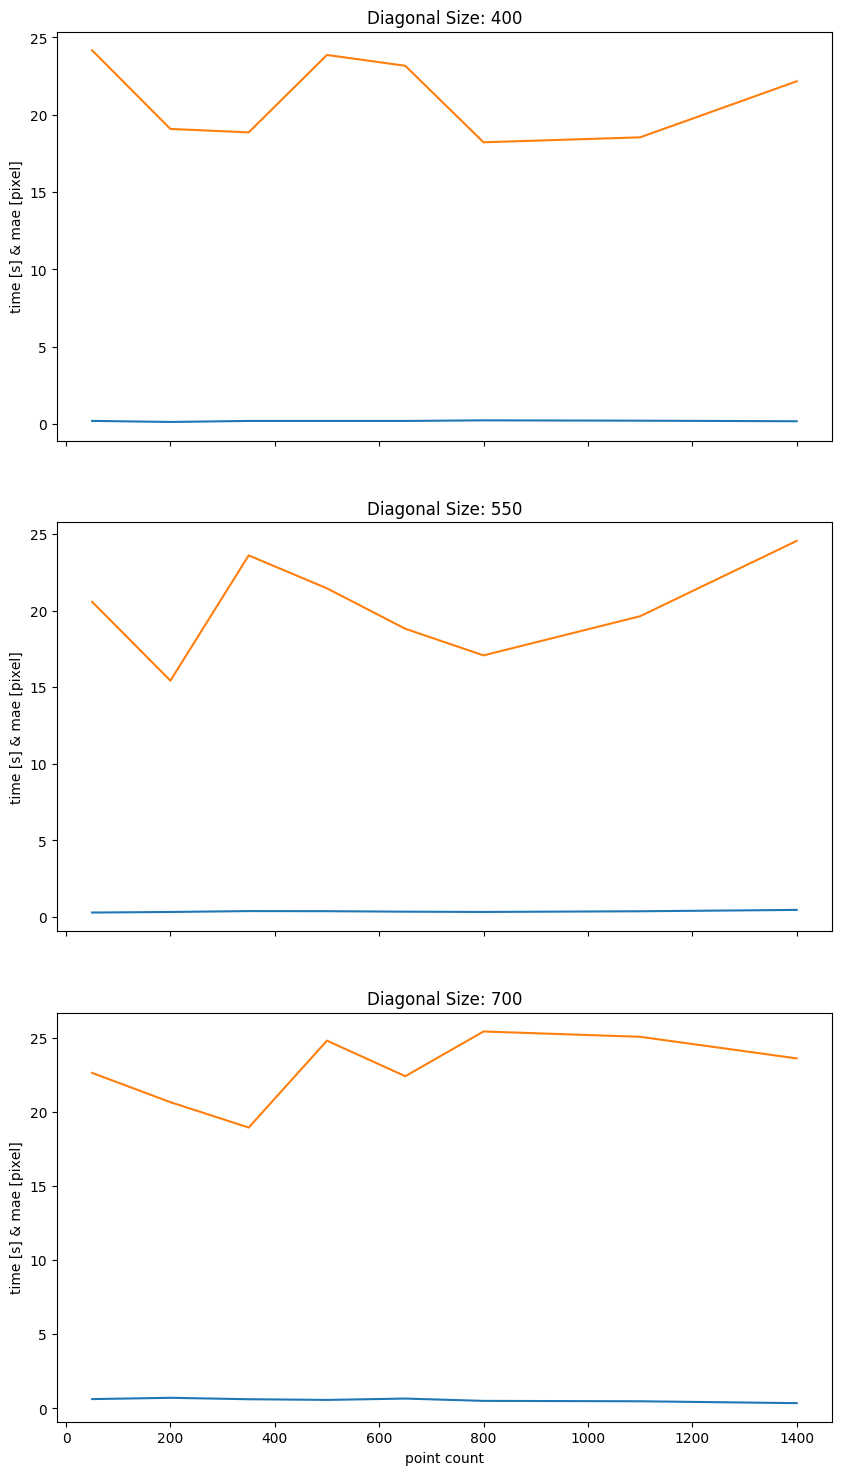

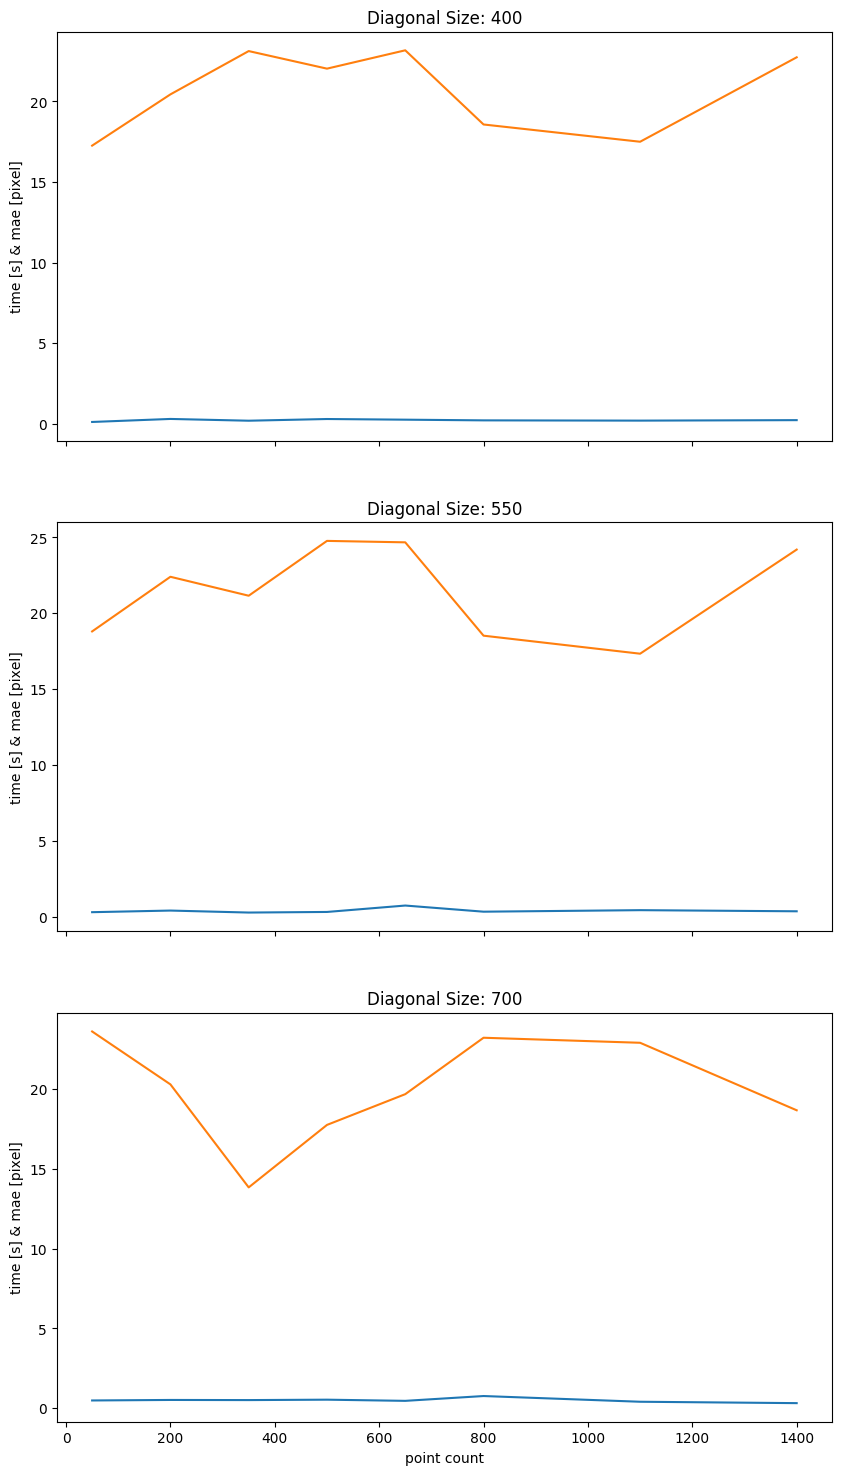

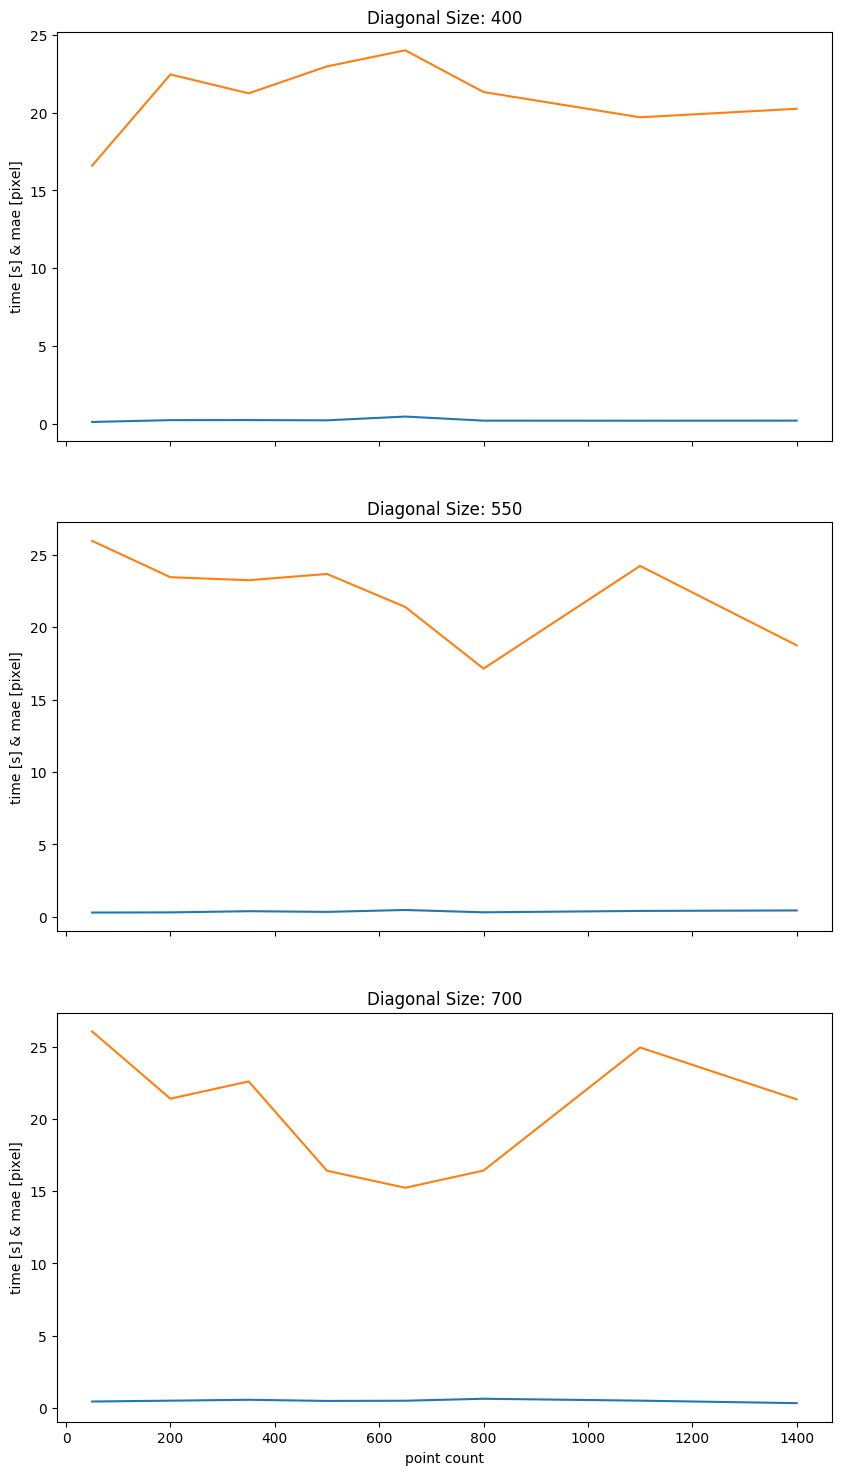

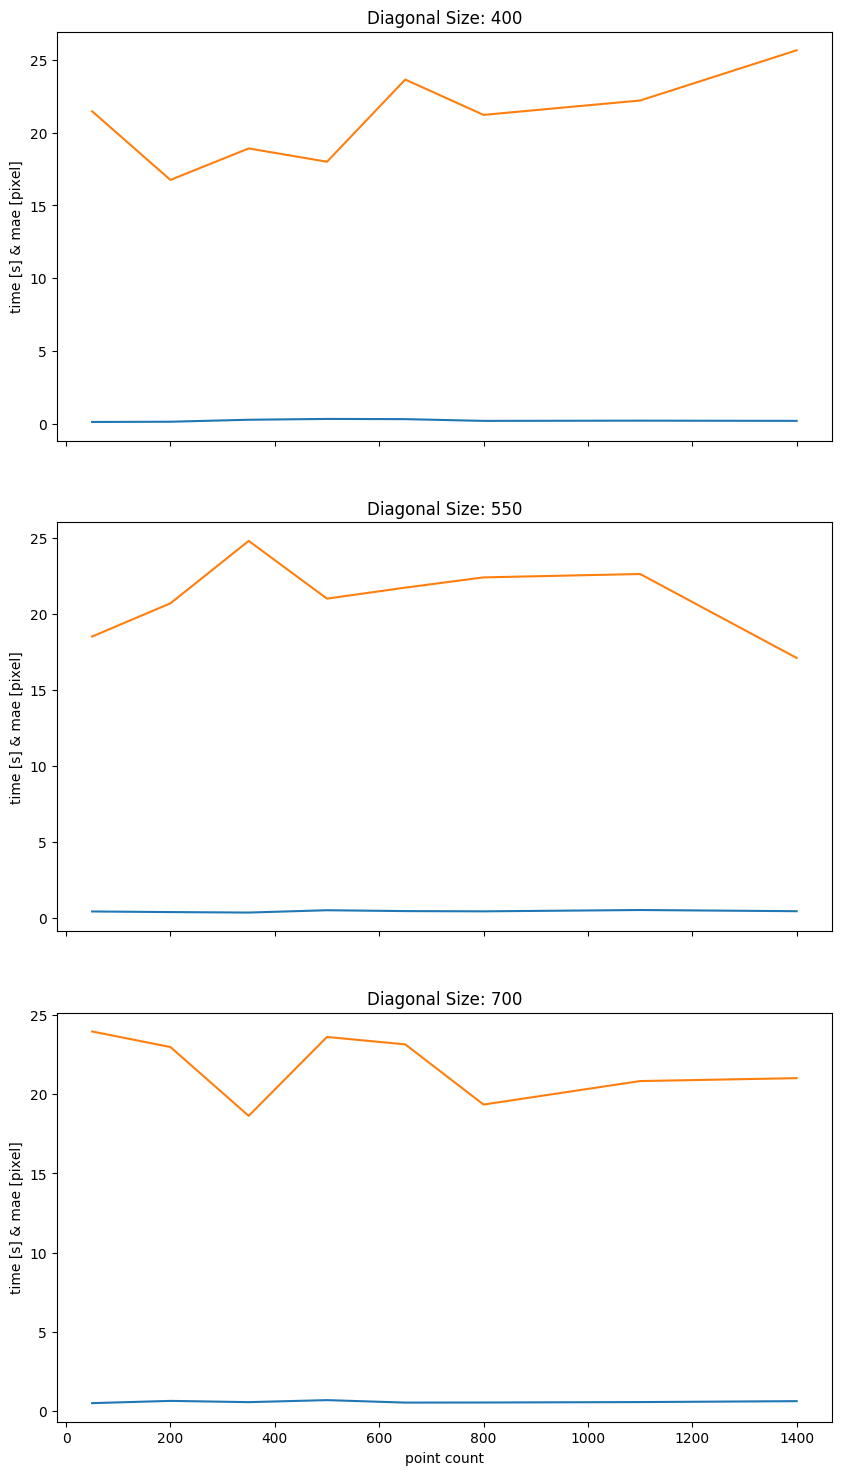

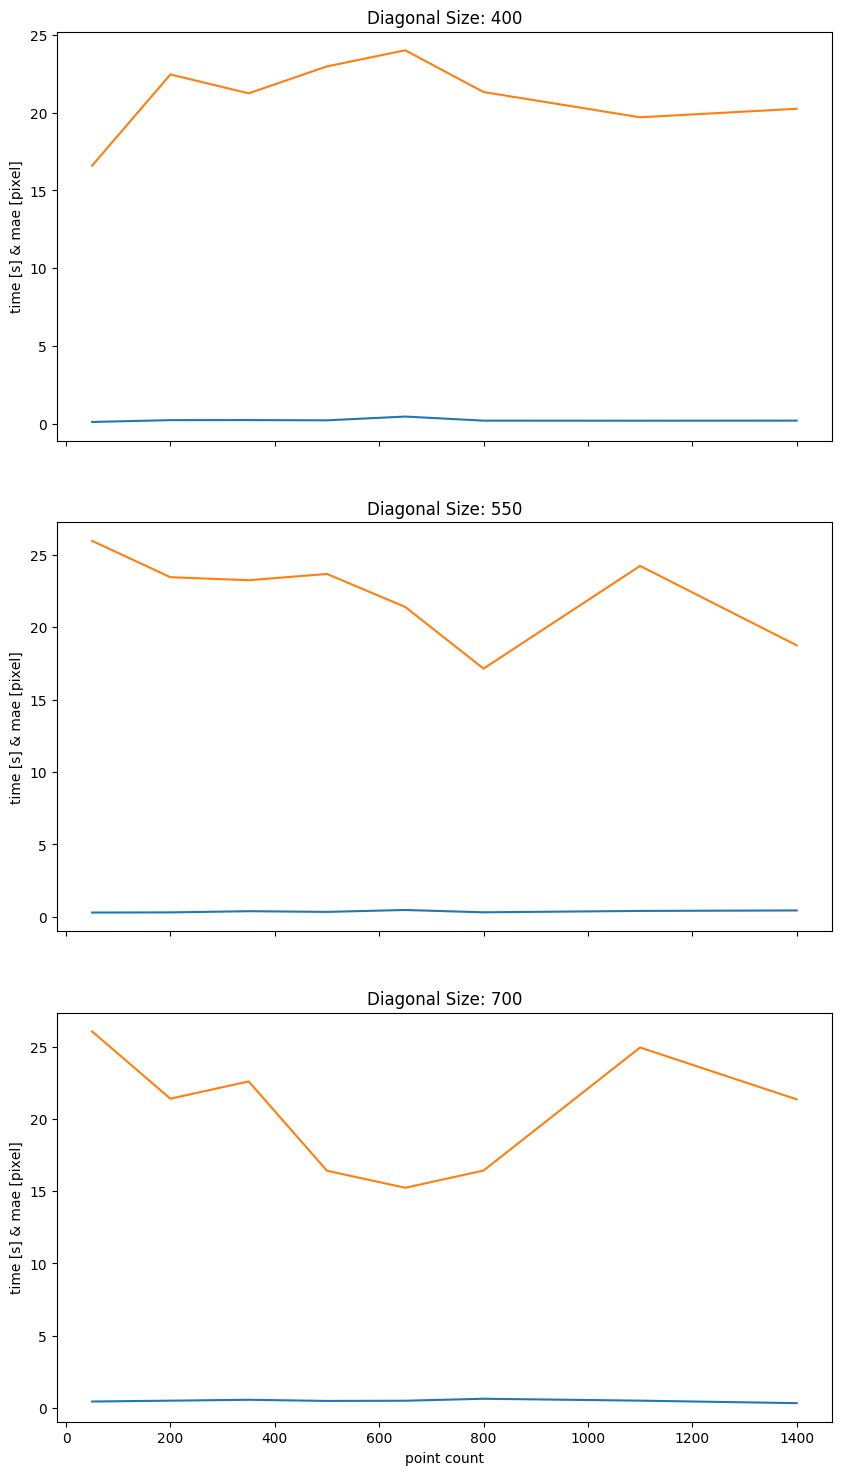

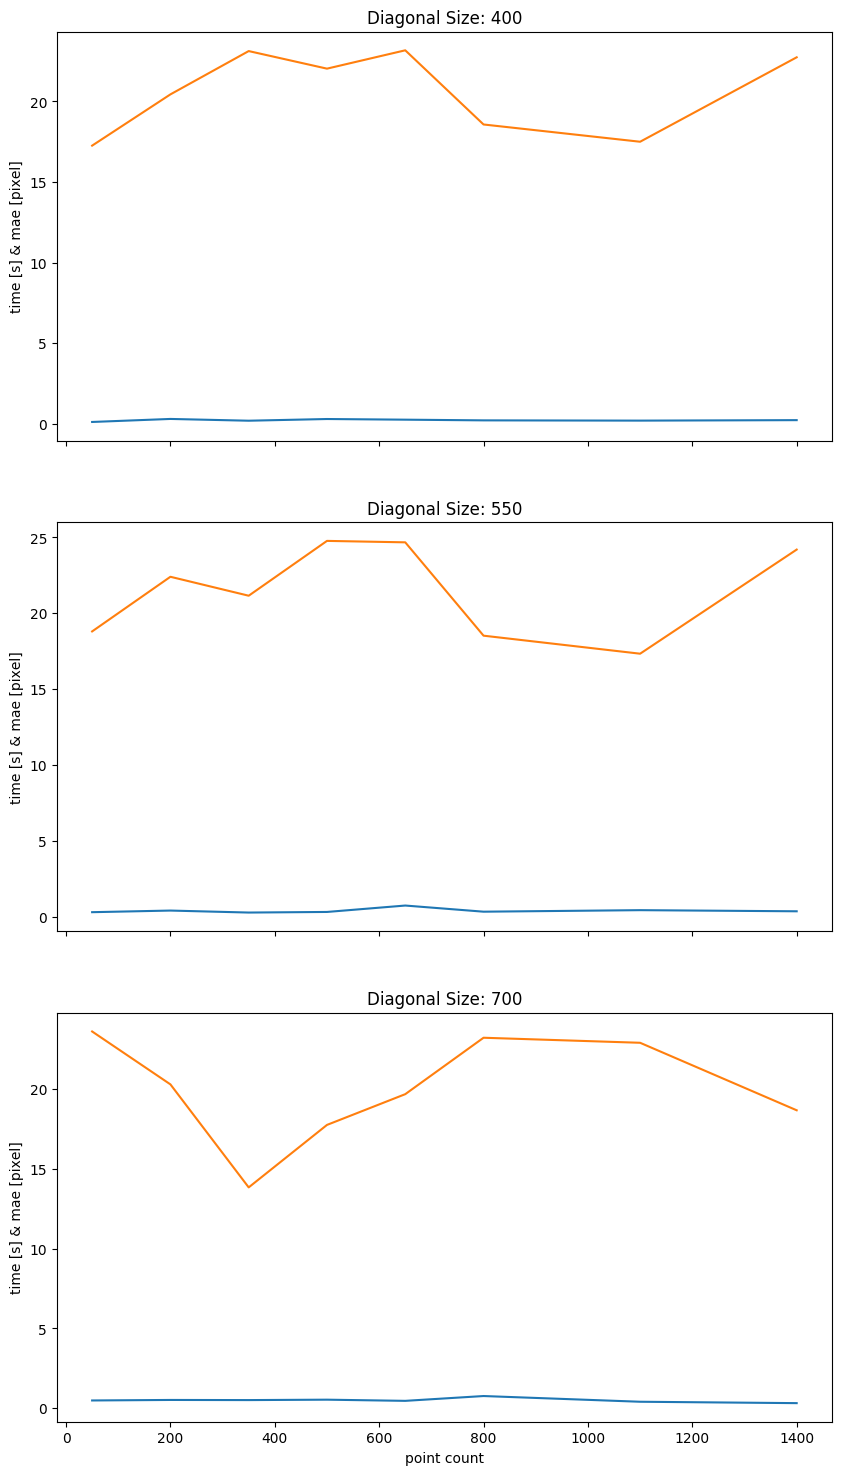

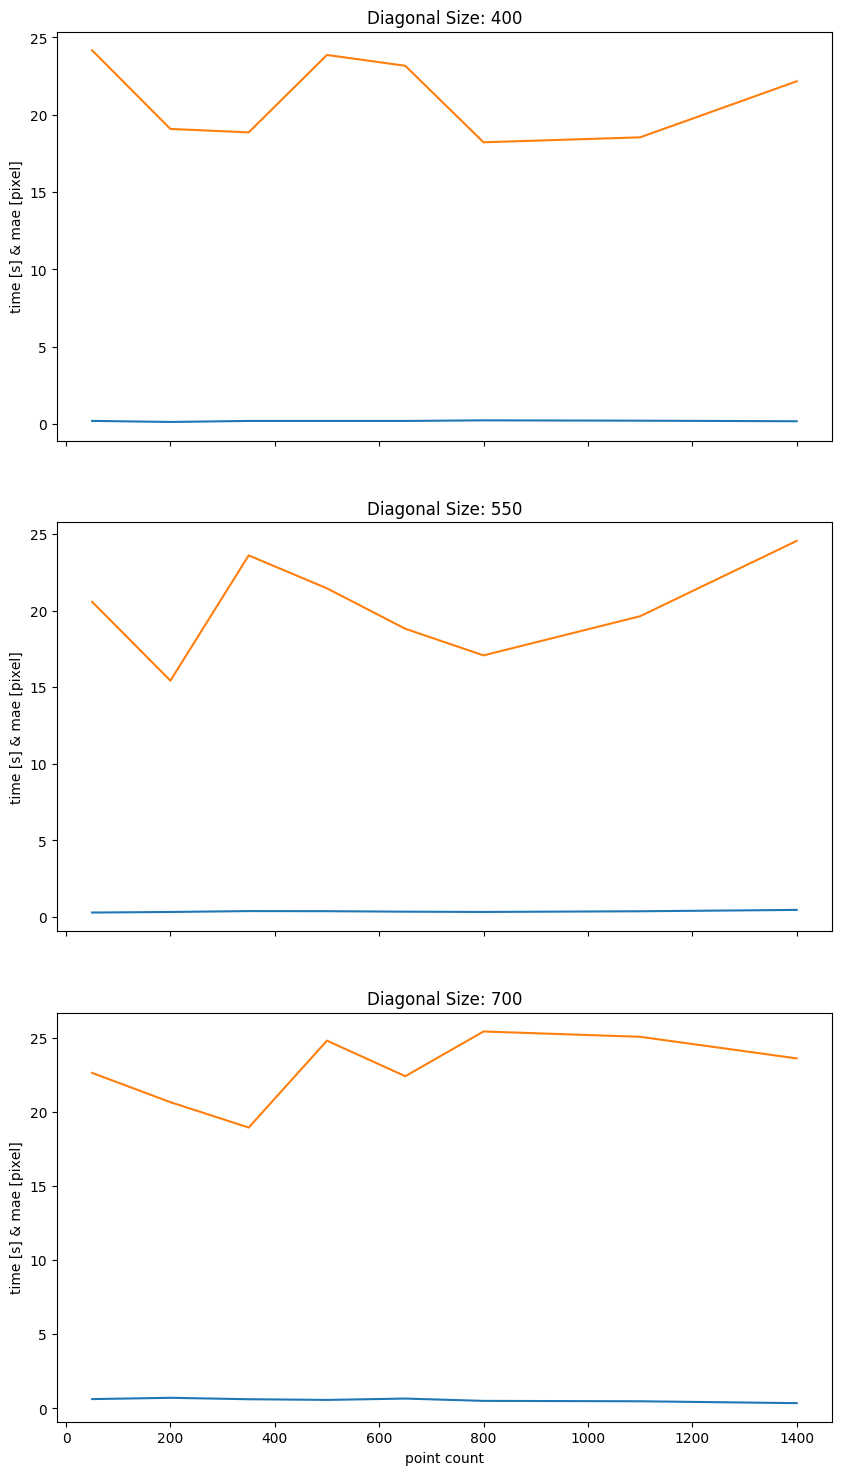

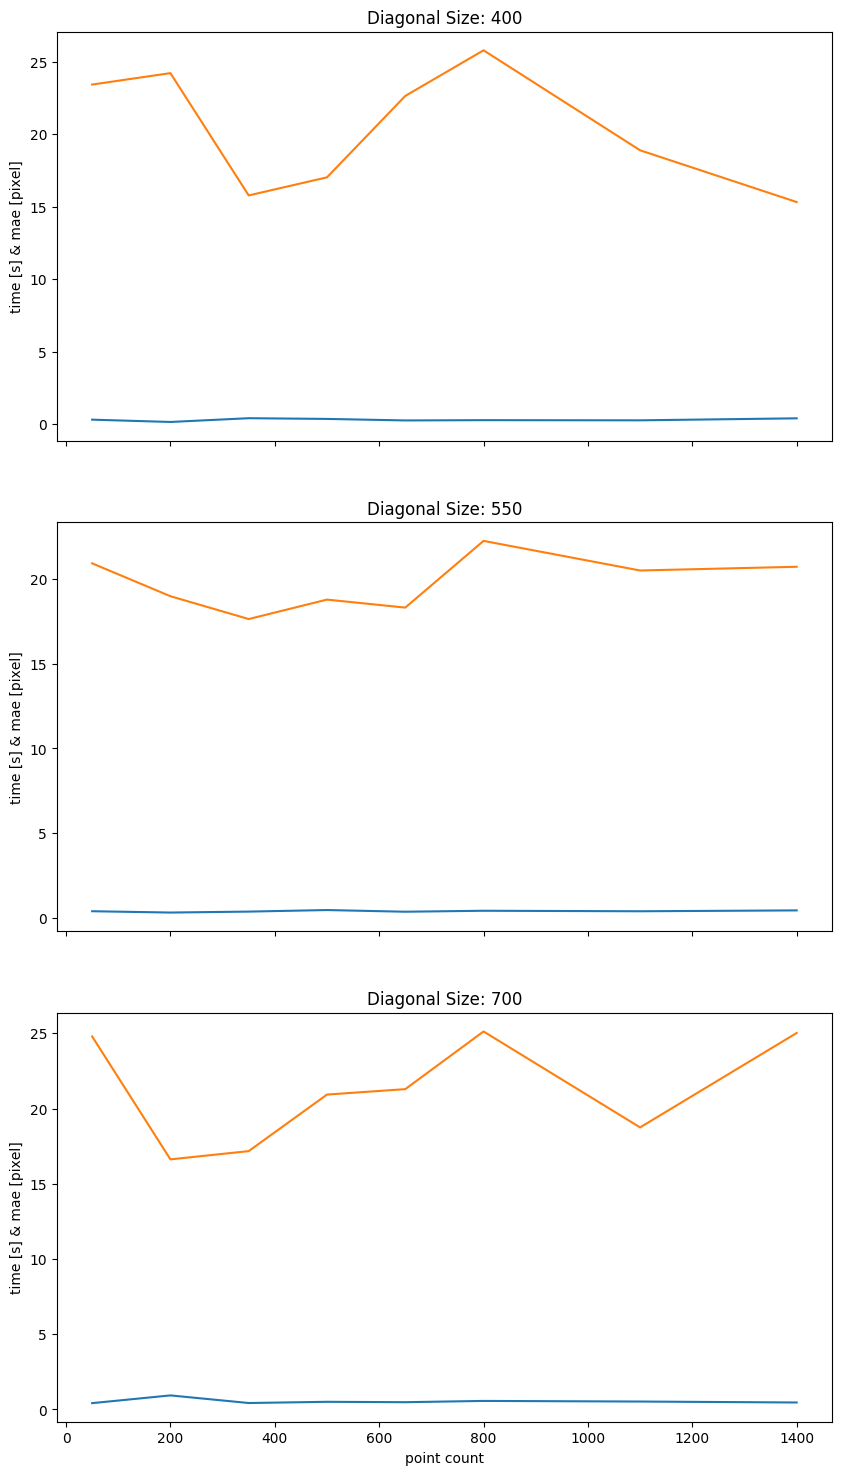

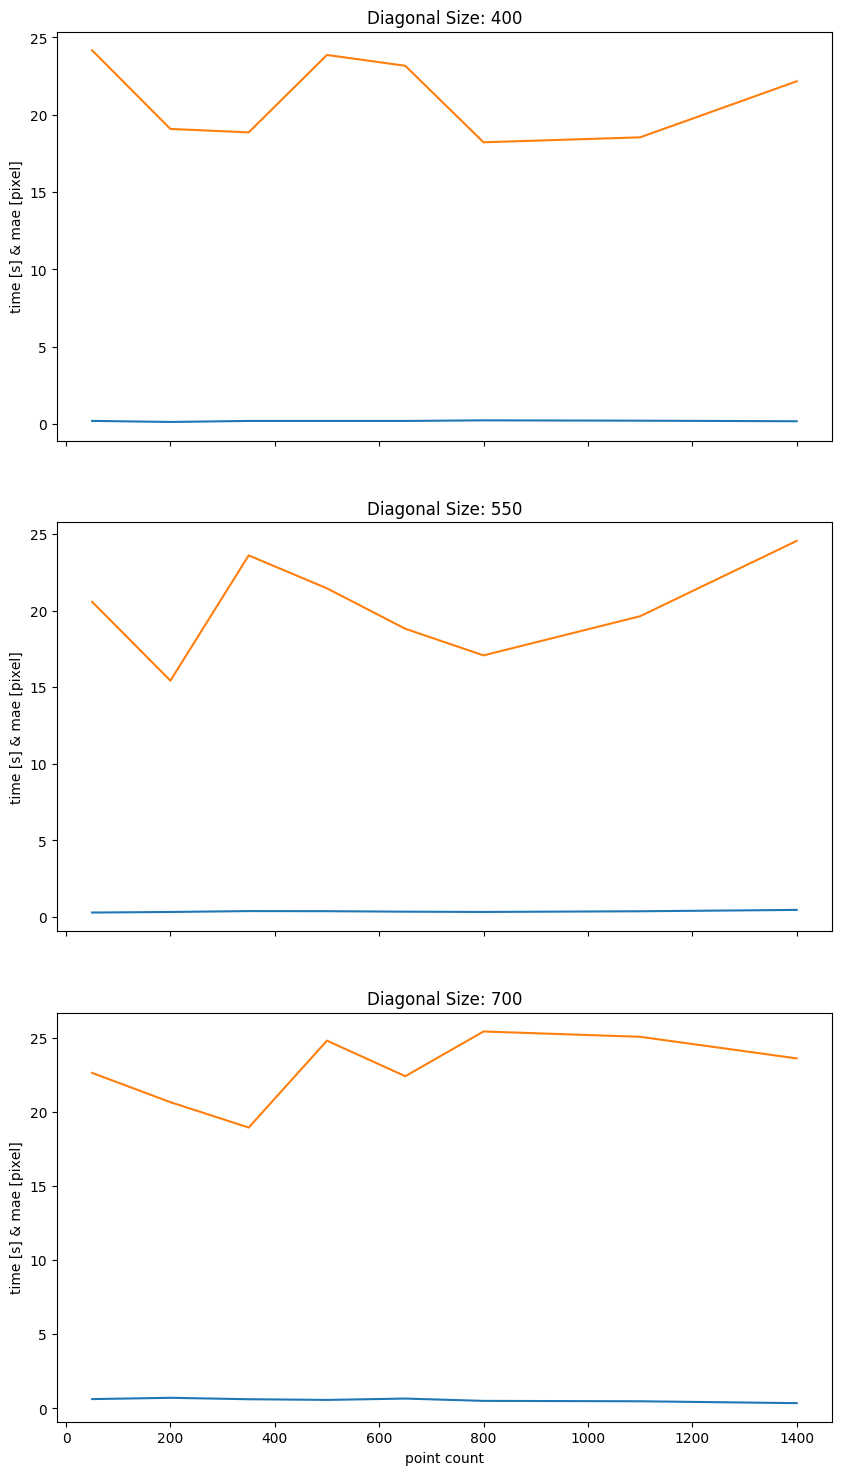

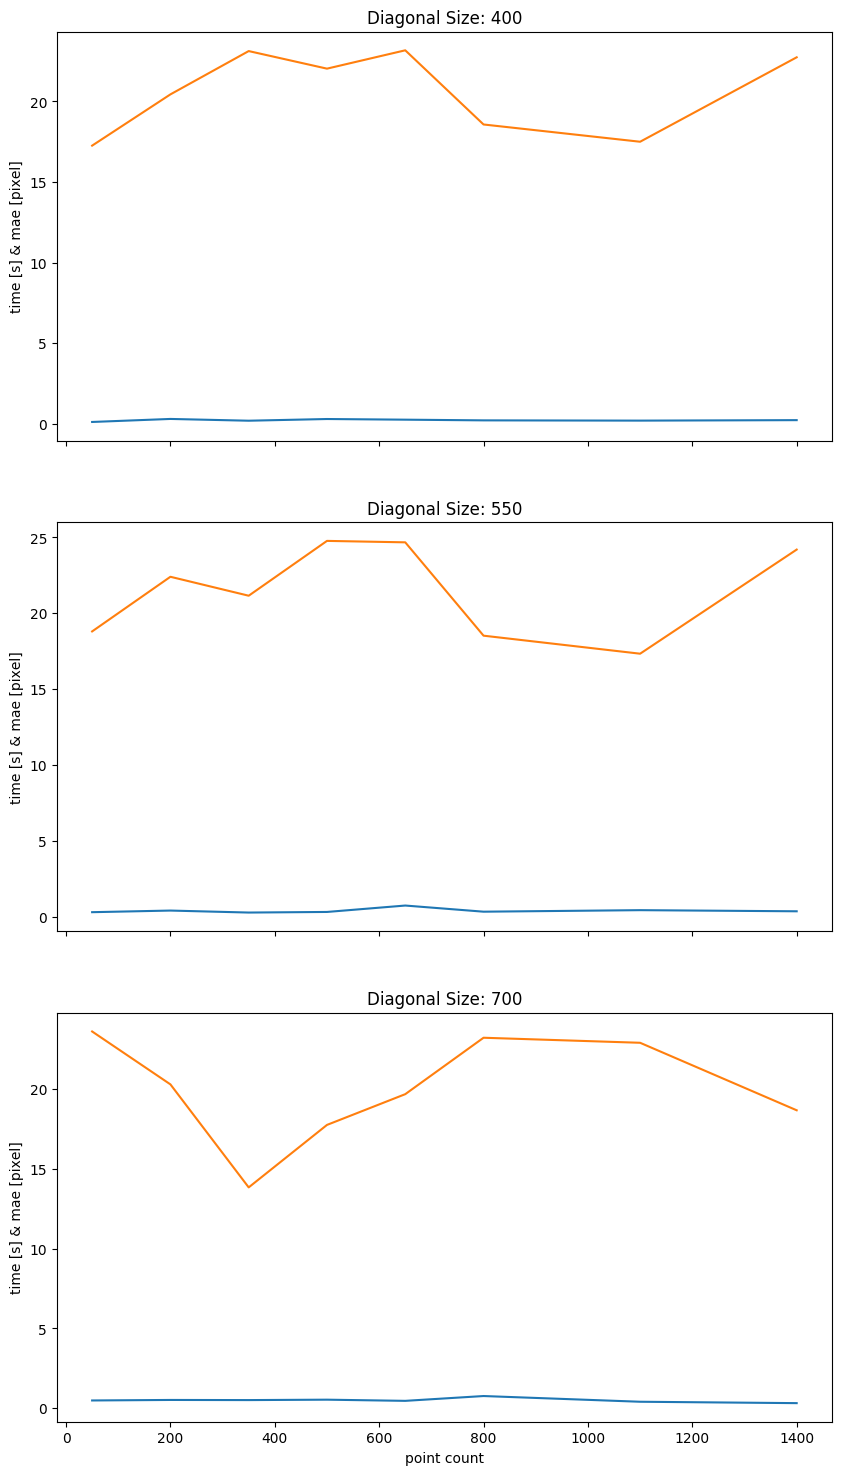

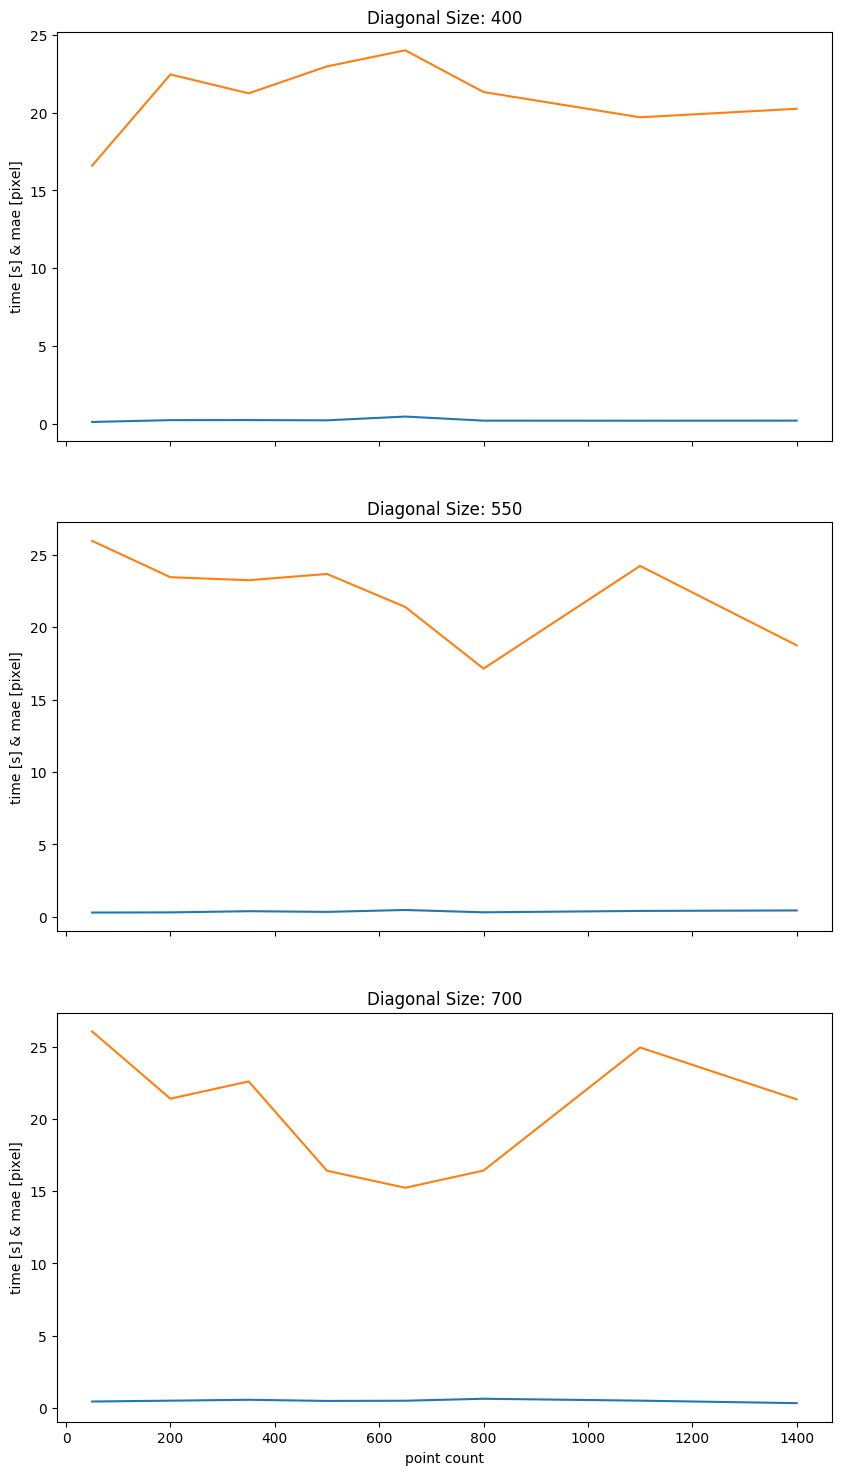

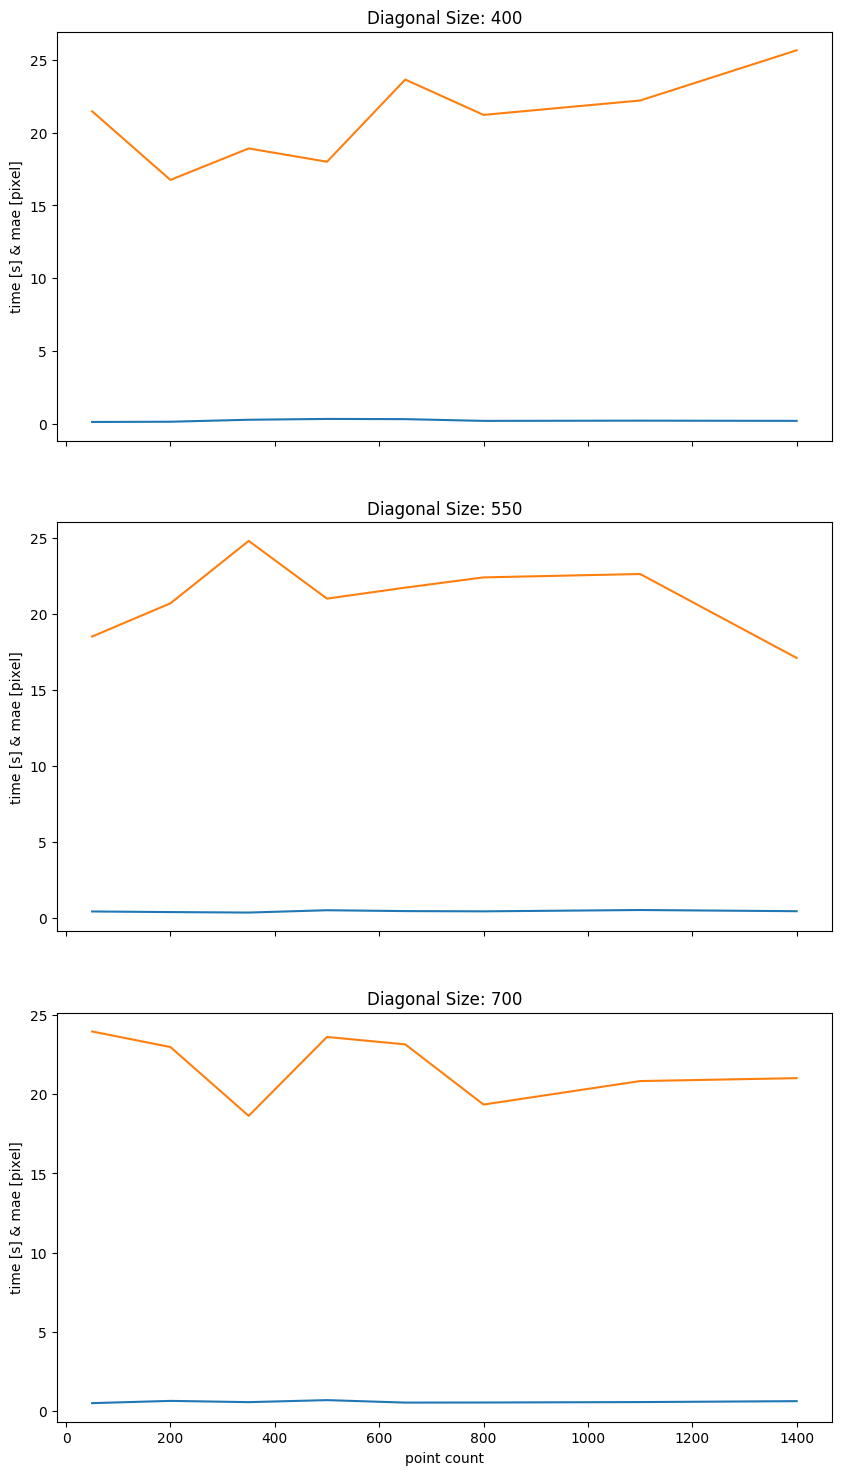

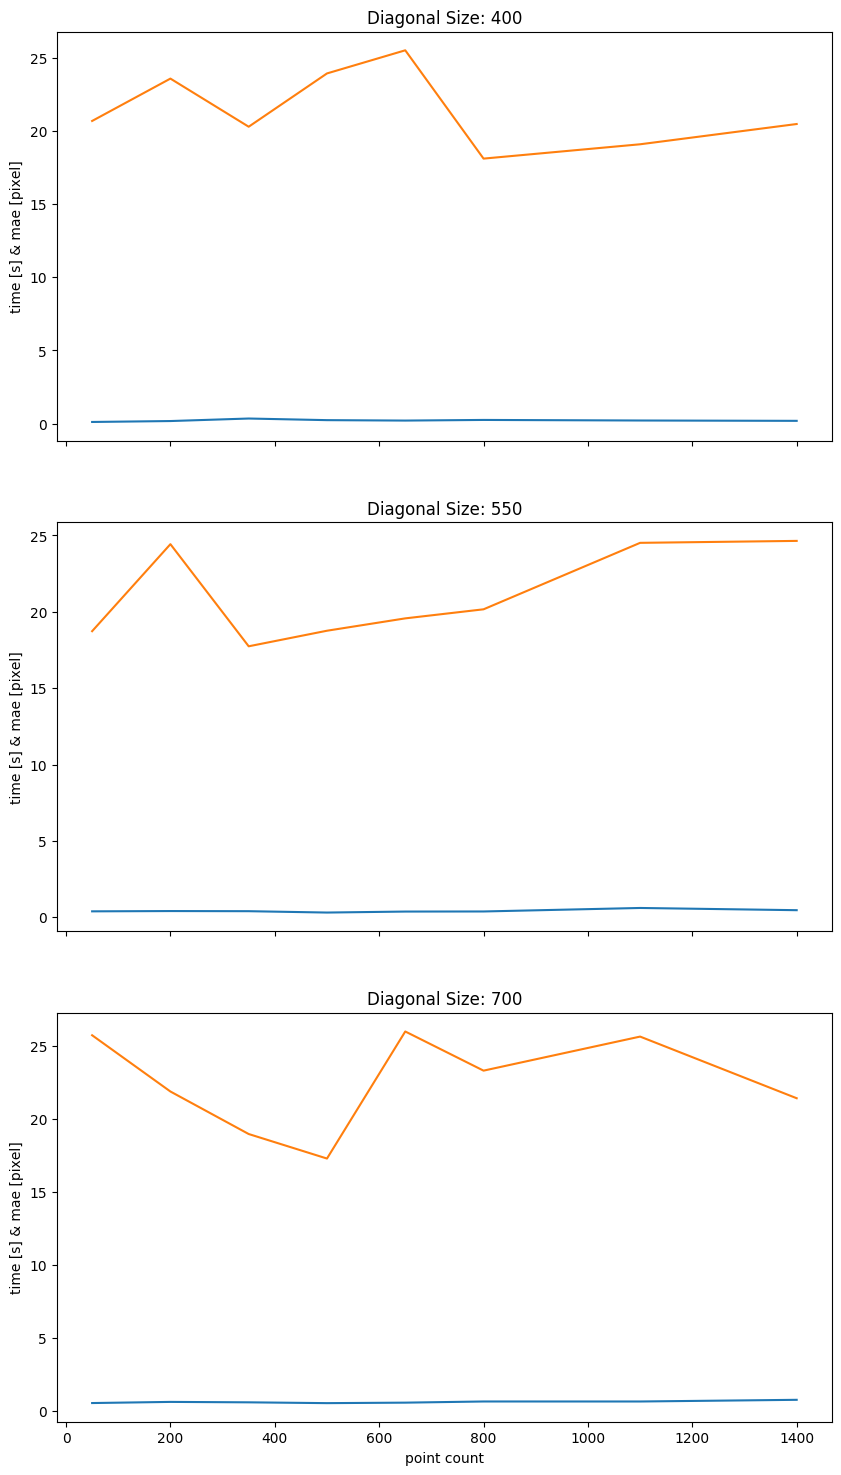

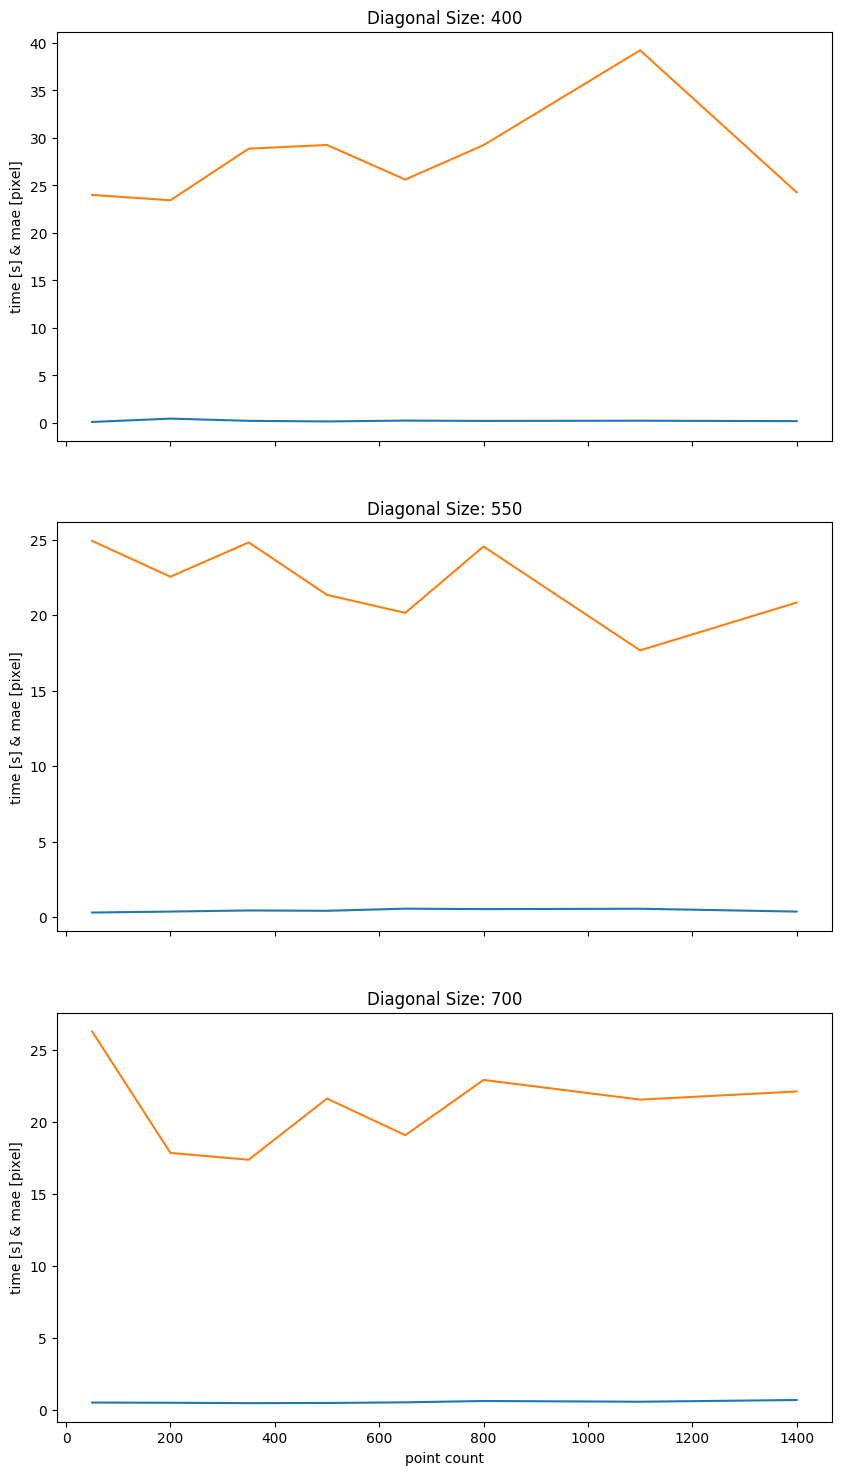

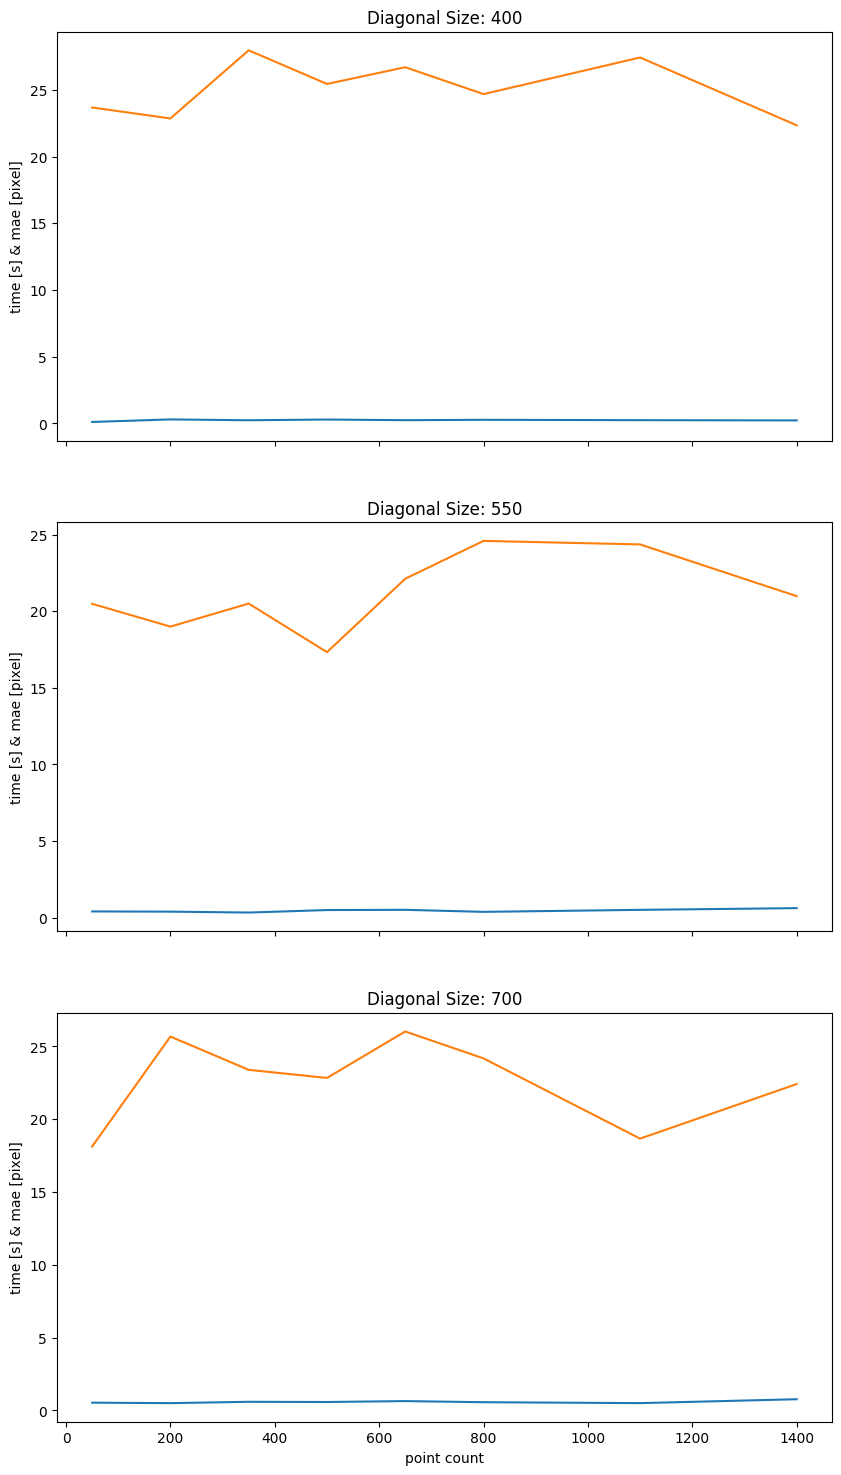

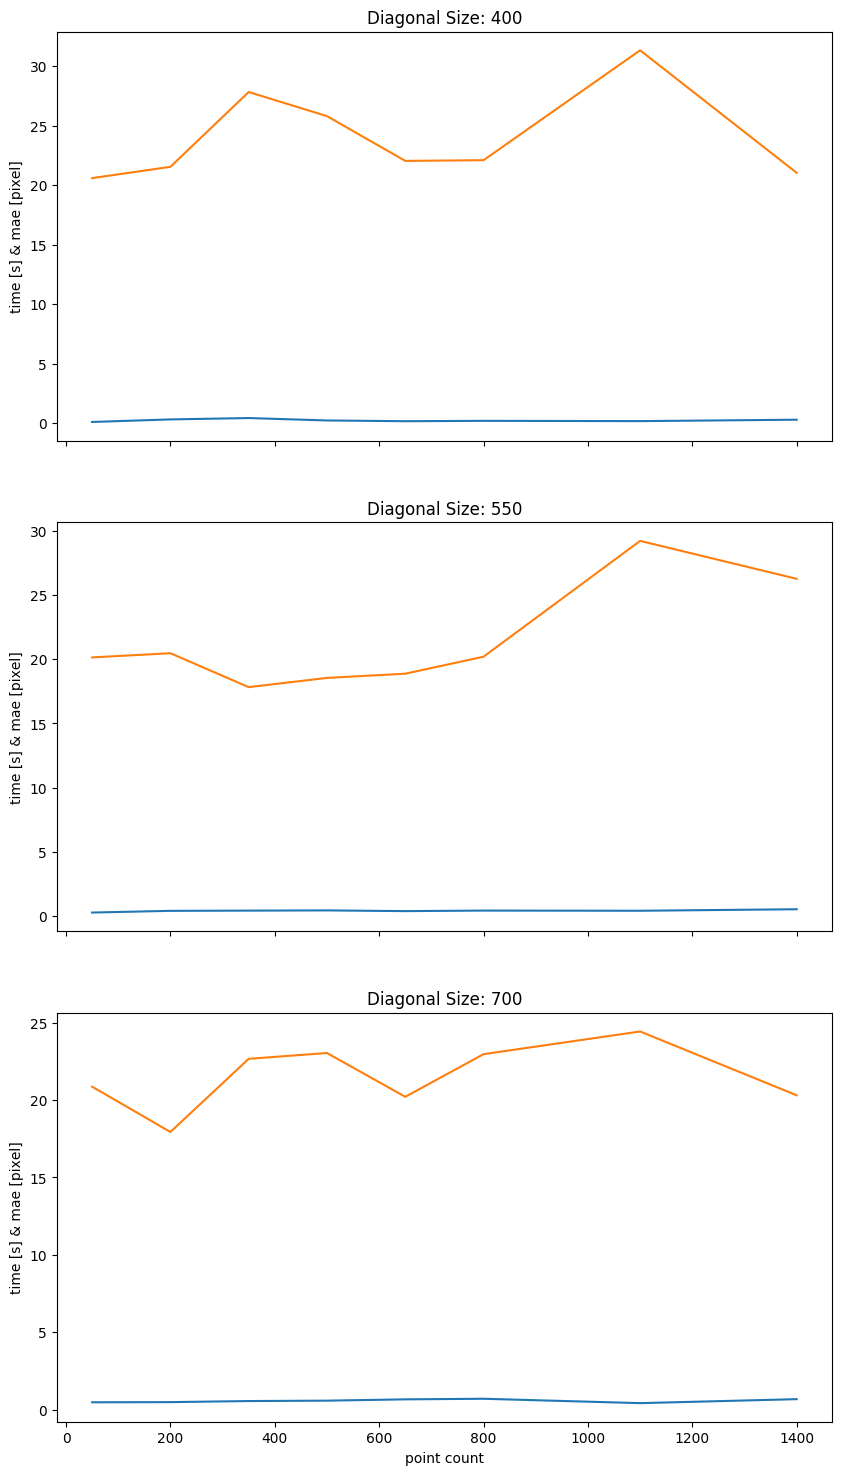

216

In [39]:
# prepare new dataframe
sp_lap_point_count = DataFrame(
    index = Int[],
    diag_size = Int[],
    whs = Int[],
    timer = TimerOutput[],
    median_results = Dict{String,Float64}[],
    point_count = Int[],
    spacing = Int[],
    points_found = Float16[]
    );

# window half sizes/half sizes of filter bases, also half this number is the maximal displacement.
#window_half_sizes = [15, 30, 45
window_half_sizes = [20]
# diagonal size of the images
diag_sizes = [400, 550, 700];
# point counts
point_counts = [50, 200, 350, 500, 650, 800, 1100, 1400]
# minimal number of pixels between two points.
#spacings = [5, 15, 35, 50, 60, 80, 100, 120, 140]
spacings = [5, 7, 10, 14, 18, 22, 26, 30, 36]
# number of anhir images used, these are warped by a known flow.
img_count = 5;

# arrays
errors = Array{Any}(undef, 0);

total_iterations = sum(broadcast(*, length.([window_half_sizes, diag_sizes, point_counts, spacings])...))

In [23]:
# prepare images:
imgs = Array{Image}(undef, 5);
for k in 1:img_count
    imgs[k], _ = gen_anhir(mutate=false); # here pass a kwarg: base_path="path/to/anhir/folder/"
end

/Users/MrTrololord/Documents/anhir/dataset/mammary-gland_2/scale-25pc/s2_61-HE_A4926-4L.jpg


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = #gen_anhir#29(::Bool, ::Int64, ::typeof(gen_anhir), ::String) at data_gen.jl:10
└ @ LAP_julia /Users/MrTrololord/Google_Drive/cvut/bakalarka/LAP_julia/src/data_gen.jl:10


/Users/MrTrololord/Documents/anhir/dataset/mammary-gland_1/scale-25pc/s1-39-HE_A4926-4L.jpg
sizes: (2946, 8918), (2580, 8424)
/Users/MrTrololord/Documents/anhir/dataset/lung-lesion_3/scale-50pc/29-041-Izd2-w35-He-les3.jpg
sizes: (6610, 8919), (6597, 8922)
/Users/MrTrololord/Documents/anhir/dataset/gastric_3/scale-15pc/CD4.jpg
sizes: (13367, 10458), (13193, 11056)
/Users/MrTrololord/Documents/anhir/dataset/lung-lesion_1/scale-50pc/29-041-Izd2-w35-CD31-3-les1.jpg
sizes: (7351, 8917), (7328, 8899)


In [40]:
# erase old_results
df = sp_lap_point_count;

## gather data

In [41]:
let index = 0
    for diag_size in diag_sizes
        for whs in window_half_sizes
            for point_count in point_counts, spacing in spacings
                timer = TimerOutput("reg alg: sp lap")
                results_dicts = Array{Dict}(undef, img_count)
                inds_array = Array{Array{Any}}(undef, img_count)

                for k in 1:img_count
                    img = resize_to_diag_size(imgs[k], diag_size)
                    whs_limited = round(Int, min(whs, min(size(img)...)/4))
                    rand_flow = gen_quad_flow(size(img), whs_limited)
                    imgw = warp_img(img, real(rand_flow), imag(rand_flow))
                    try
                        # run registration function
                        _, _, timer, results_dicts[k], (_, inds_array[k]) = test_registration_alg(sparse_lap,
                            img, imgw, rand_flow, [whs_limited], Dict(:timer => timer, :point_count =>
                                point_count, :spacing => spacing), timer=timer, display=false)
                    catch e
                        println(e)
                        push!(errors, [e, img, imgw, rand_flow, whs_limited])
                        continue
                    end
                end
                # if no data gathered:
                if any(x-> 0 .== x, length.([results_dicts, inds_array]))
                    println("SKIPPED: diag_size:", diag_size, " whs: ", whs)
                    continue
                end

                median_results = fun_on_dict_values(filter_defined(results_dicts), median)
                avg_points_found = LAP_julia.mean(map(x -> length(x), filter_defined(inds_array)))

                index = index + 1
                println("at index: ", index, " (of $total_iterations) ", " diag_size: ", diag_size, " whs: ", whs)
                push!(df, Dict(:index => index,
                               :diag_size => diag_size,
                               :whs => whs,
                               :timer => timer,
                               :median_results => median_results,
                               :point_count => point_count,
                               :spacing => spacing,
                               :points_found => avg_points_found
                               ))
            end # point_count in point_counts, spacing in spacings
        end
    end
end

at index: 1 (of 216)  diag_size: 400 whs: 20
at index: 2 (of 216)  diag_size: 400 whs: 20
at index: 3 (of 216)  diag_size: 400 whs: 20
at index: 4 (of 216)  diag_size: 400 whs: 20
at index: 5 (of 216)  diag_size: 400 whs: 20
at index: 6 (of 216)  diag_size: 400 whs: 20
at index: 7 (of 216)  diag_size: 400 whs: 20
at index: 8 (of 216)  diag_size: 400 whs: 20
at index: 9 (of 216)  diag_size: 400 whs: 20
at index: 10 (of 216)  diag_size: 400 whs: 20
at index: 11 (of 216)  diag_size: 400 whs: 20
at index: 12 (of 216)  diag_size: 400 whs: 20
at index: 13 (of 216)  diag_size: 400 whs: 20
at index: 14 (of 216)  diag_size: 400 whs: 20
at index: 15 (of 216)  diag_size: 400 whs: 20
at index: 16 (of 216)  diag_size: 400 whs: 20
at index: 17 (of 216)  diag_size: 400 whs: 20
at index: 18 (of 216)  diag_size: 400 whs: 20
at index: 19 (of 216)  diag_size: 400 whs: 20
at index: 20 (of 216)  diag_size: 400 whs: 20
at index: 21 (of 216)  diag_size: 400 whs: 20
at index: 22 (of 216)  diag_size: 400 whs: 

at index: 178 (of 216)  diag_size: 700 whs: 20
at index: 179 (of 216)  diag_size: 700 whs: 20
at index: 180 (of 216)  diag_size: 700 whs: 20
at index: 181 (of 216)  diag_size: 700 whs: 20
at index: 182 (of 216)  diag_size: 700 whs: 20
at index: 183 (of 216)  diag_size: 700 whs: 20
at index: 184 (of 216)  diag_size: 700 whs: 20
at index: 185 (of 216)  diag_size: 700 whs: 20
at index: 186 (of 216)  diag_size: 700 whs: 20
at index: 187 (of 216)  diag_size: 700 whs: 20
at index: 188 (of 216)  diag_size: 700 whs: 20
at index: 189 (of 216)  diag_size: 700 whs: 20
at index: 190 (of 216)  diag_size: 700 whs: 20
at index: 191 (of 216)  diag_size: 700 whs: 20
at index: 192 (of 216)  diag_size: 700 whs: 20
at index: 193 (of 216)  diag_size: 700 whs: 20
at index: 194 (of 216)  diag_size: 700 whs: 20
at index: 195 (of 216)  diag_size: 700 whs: 20
at index: 196 (of 216)  diag_size: 700 whs: 20
at index: 197 (of 216)  diag_size: 700 whs: 20
at index: 198 (of 216)  diag_size: 700 whs: 20
at index: 199

In [36]:
# save df
@save "df_point_count_save.jld2" df

## Visualise results

In [31]:
timers = df[((df.diag_size .== 400) .& (df.spacing .== 5)), :][:, :timer]

8-element Array{TimerOutput,1}:
  ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:           16357s / 0.01%            632GiB / 0.03%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 reg alg: sp lap            5    1.52s   100%   304ms    174MiB  100%   34.8MiB
   sparse lap               5    1.29s  85.2%   259ms    115MiB  66.1%  23.0MiB
     multi mat div          5    582ms  38.3%   116ms   16.9MiB  9.73%  3.39MiB
     filtering              5    566ms  37.3%   113ms   60.2MiB  34.6%  12.0MiB
     prepare A and b        5   68.5ms  4.51%  13.7ms   30.1MiB  17.3%  6.02MiB
       window sum p...     15   43.0ms  2.83%  2.87ms   18.1MiB  10.4%  1.20MiB
      

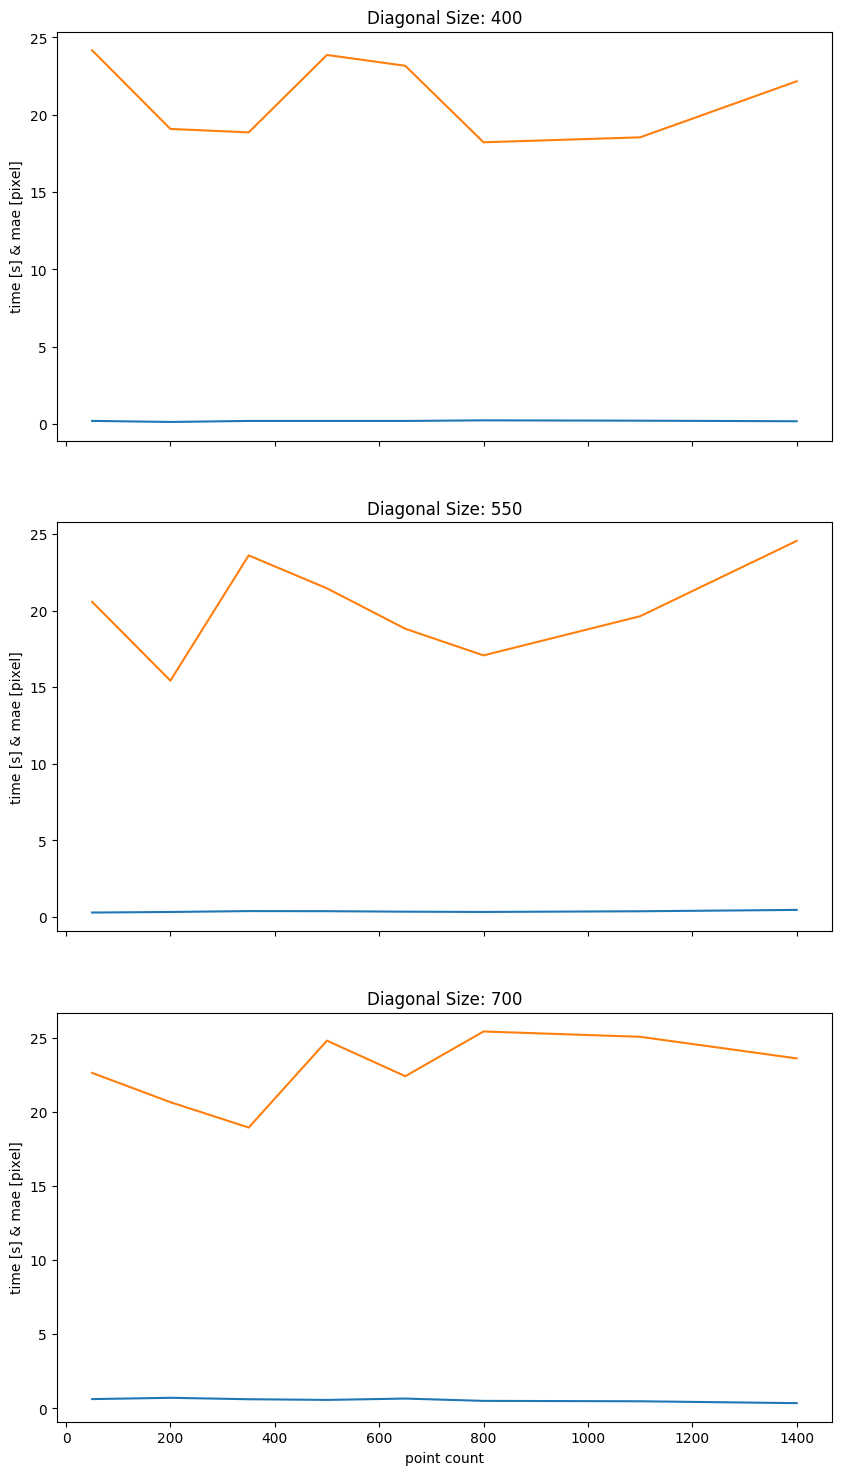

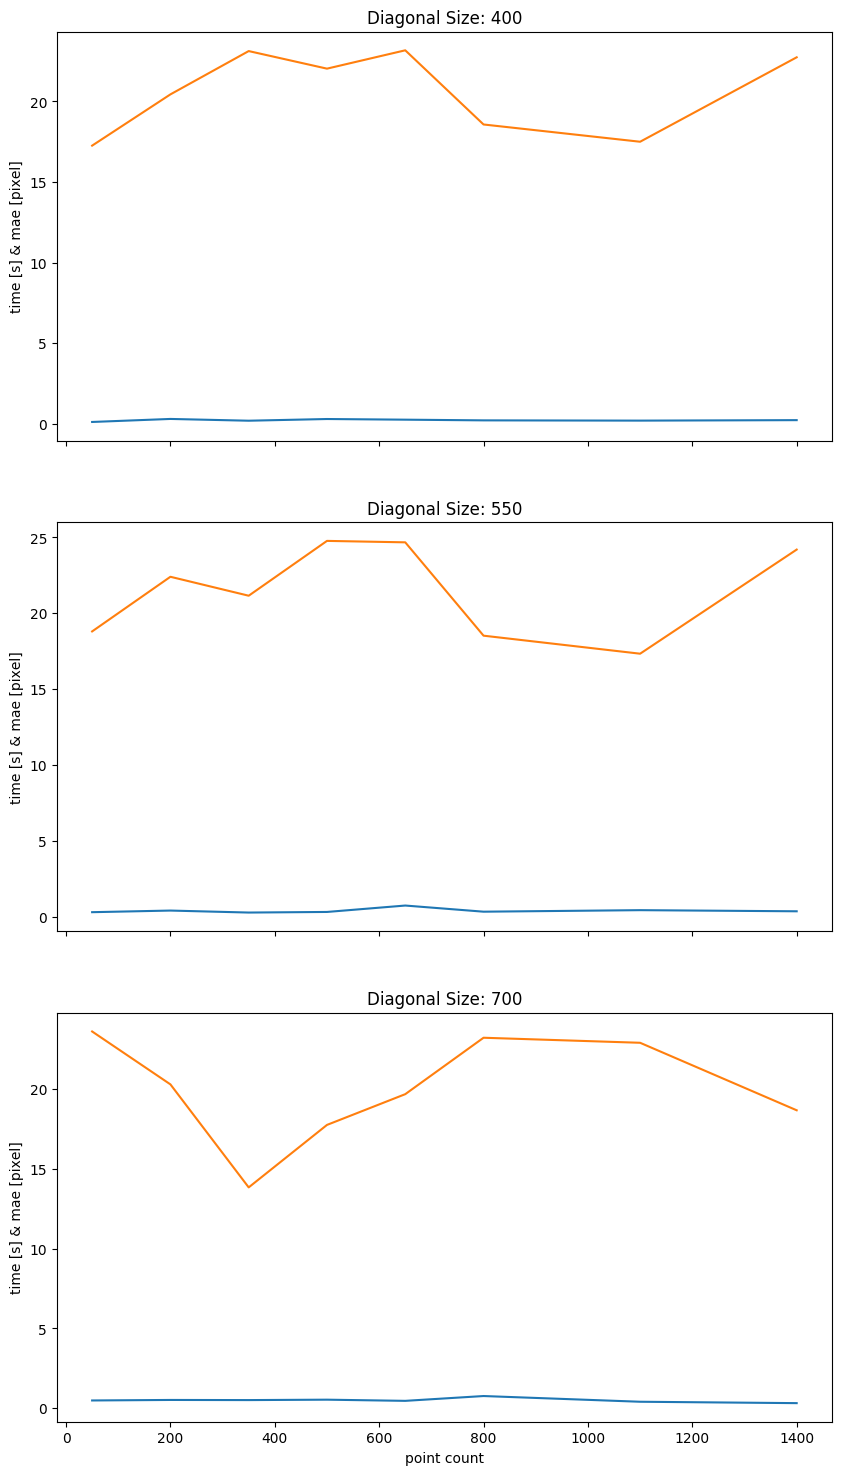

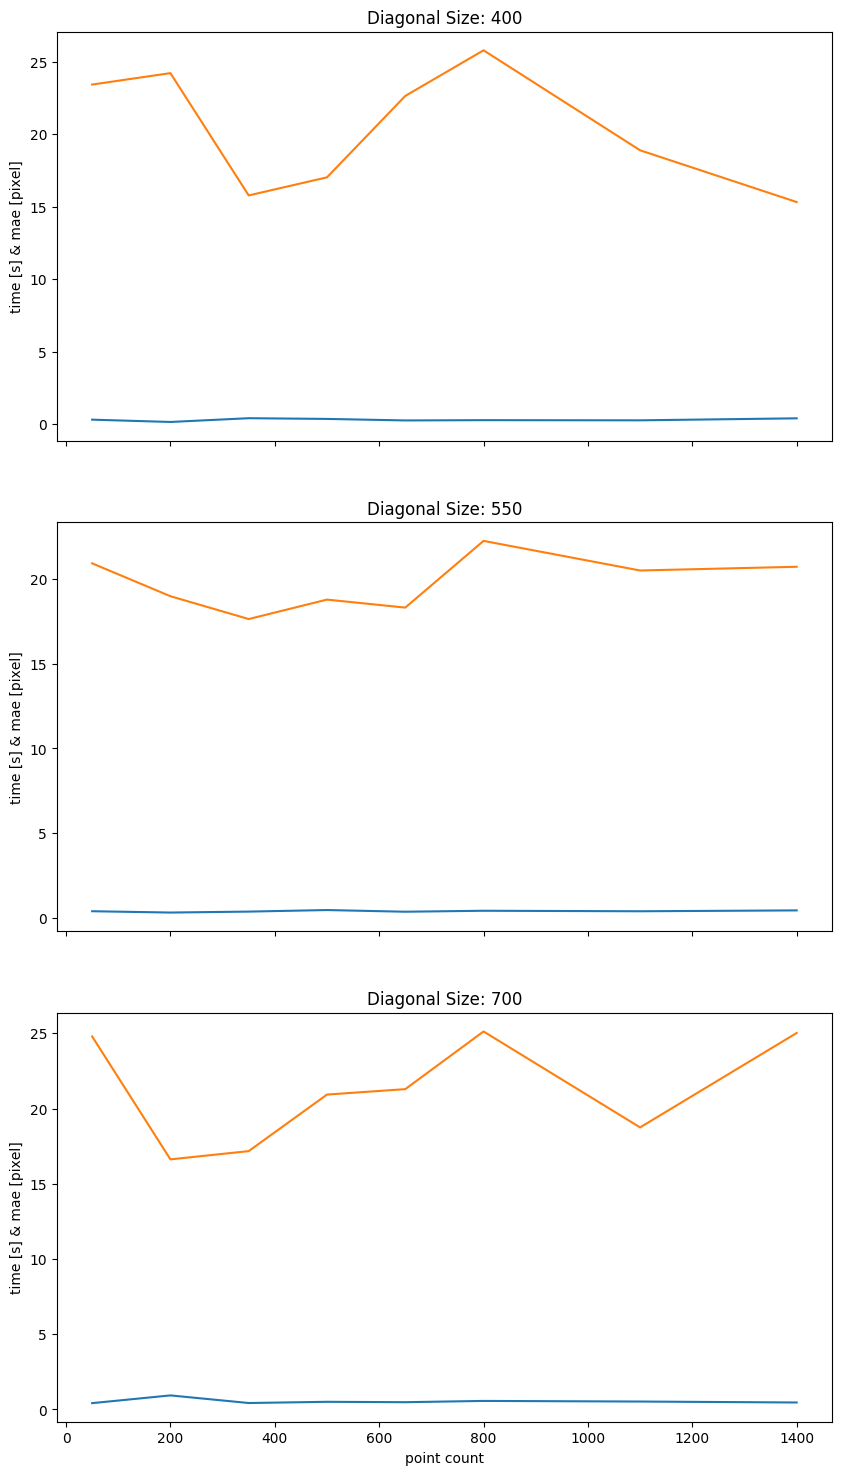

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["spacing"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 9,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
1, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/MrTrololord/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/MrTrololord/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/MrTrololord/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/Users/MrTrololord/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/Users/MrTrololord/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000001168def50, Task (runnable) @0x00000001168def50), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"14927261091382749081\",\"id\":\"ob_16\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\

In [38]:
sections = ["reg alg: sp lap"]
@manipulate for k in slider(1:length(spacings), value=1, label="spacing")
    spacing = spacings[k]
    fig, axs = subplots(length(diag_sizes), sharex=true, figsize=(10,10))
    for (diag_size, ax) in zip(diag_sizes, axs)
        ax.set_title("Diagonal Size: " * string(diag_size))

        local_df = df[((df.diag_size .== diag_size) .& (df.spacing .== spacing)), :]

        # get times
        timers = local_df[:, :timer]
        avg_times = map(x -> get_avg_time(get_timer(x, sections)), timers)

        # get flow mae
        median_dicts = local_df[:, :median_results]
        median_flow_mae = map(dict -> dict["flow_mae"], median_dicts)

        # xscale("log")
        # yscale("log")
        subplots_adjust(top=1.5)
        ax.plot(point_counts, avg_times)
        ax.plot(point_counts, median_flow_mae)
        xlabel("point count")
        ax.set_ylabel("time [s] & mae [pixel]")
    end
end

### helper functions

In [34]:
defined_perms(arraylike) = filter(k -> isassigned(arraylike, k), 1:length(arraylike))
filter_defined(arraylike) = arraylike[defined_perms(arraylike)]
function get_avg_time(timer)
    return (TimerOutputs.time(timer)/TimerOutputs.ncalls(timer))/10e8
end
function get_timer(timer, sections)
    private_sections = copy(sections)
    try
        timer[private_sections[1]]
    catch e
        println(e)
        return TimerOutput()
    end
    out = timer
    while private_sections != []
        out = out[popfirst!(private_sections)]
    end
    return out
end

get_timer (generic function with 1 method)